<a href="https://colab.research.google.com/github/JyotsnaAkavarapu/AIML_TUTORIALiiith/blob/main/Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [6]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                # Calculate the linear output (w * x + b)
                prediction = np.dot(X[i], self.w) + self.b

                # If prediction is a mistake (y * prediction <= 0):
                if y[i] * prediction <= 0:
                    # Update weights: w = w + lr * y * x
                    self.w += self.lr * y[i] * X[i]
                    # Update bias: b = b + lr * y
                    self.b += self.lr * y[i]
                    count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [7]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            # 1. Compute linear output: z = Xw + b
            z = np.dot(X, self.w) + self.b

            # Calculate cost (MSE)
            cost = (1/(2*n)) * np.sum((z - y)**2)
            self.cost_history.append(cost)

            # 2. Calculate gradients:
            dw = (1/n) * np.dot(X.T, (z - y))
            db = (1/n) * np.sum(z - y)

            # 3. Update w and b: w = w - lr * dw
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [15]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                # Margin Condition check: y_i * (w * x_i + b) >= 1
                # If the sample is correctly classified with a margin of 1
                if y[i] * (np.dot(self.w, x_i) + self.b) >= 1:
                    # Only Regularization update
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Update for weight (including Hinge Loss) and bias
                    # Gradient for w: -y_i * x_i + 2 * lambda_param * w
                    self.w -= self.lr * (-y[i] * x_i + 2 * self.lambda_param * self.w)
                    # Gradient for b: -y_i
                    self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

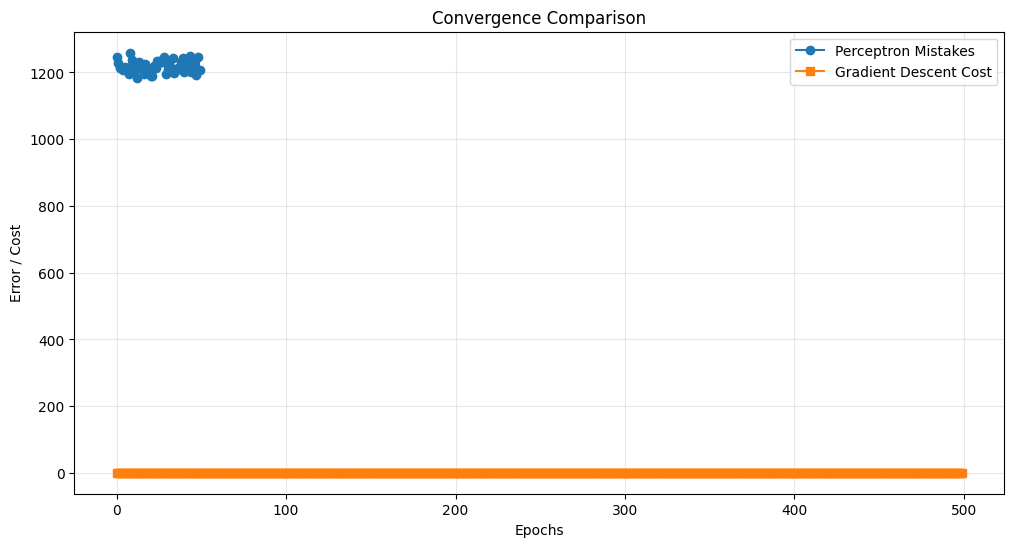

In [11]:
#1. Plot convergence

plt.figure(figsize=(12,6))

# Perceptron mistakes
plt.plot(model_p.mistakes,
         label="Perceptron Mistakes",
         marker='o')

# Gradient Descent cost
plt.plot(model_gd.cost_history,
         label="Gradient Descent Cost",
         marker='s')

plt.xlabel("Epochs")
plt.ylabel("Error / Cost")
plt.title("Convergence Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [10]:
model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

2.Accuracy report

In [16]:
model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# Predictions
y_pred_p = model_p.predict(X_test)
y_pred_gd = model_gd.predict(X_test)
y_pred_m = model_margin.predict(X_test)

# Accuracy
acc_p = accuracy_score(y_test, y_pred_p)
acc_gd = accuracy_score(y_test, y_pred_gd)
acc_m = accuracy_score(y_test, y_pred_m)

print("Perceptron Accuracy:", acc_p*100)
print("Gradient Descent Accuracy:", acc_gd*100)
print("Margin Classifier Accuracy:", acc_m*100)


Perceptron Accuracy: 50.15243902439024
Gradient Descent Accuracy: 62.80487804878049
Margin Classifier Accuracy: 62.80487804878049


# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


1.A very high learning rate causes overshooting of the minimum. The model may oscillate around the optimum or diverge completely, leading to unstable training and failure to converge.

2.Labels are converted to {-1,1} because many linear classifiers and hinge loss formulations require symmetric labels. This simplifies mathematical expressions and allows direct computation of margins and gradients.

3.The Margin classifier is best suited for noisy data because it maximizes class separation and uses regularization, making it robust to outliers and overlapping samples.


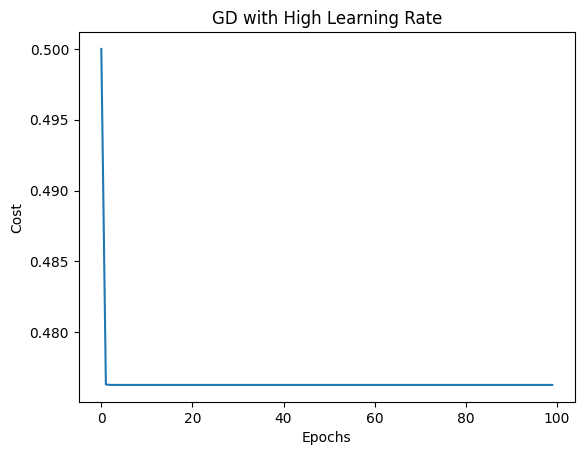

In [18]:
# High learning rate test
model_gd_fast = GDWaterClassifier(lr=1.0, epochs=100)
model_gd_fast.fit(X_train, y_train)

plt.plot(model_gd_fast.cost_history)
plt.title("GD with High Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()
